<a href="https://colab.research.google.com/github/alfawzaan/deep-learning-projects/blob/master/Crop_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

import pandas as pd

use_cuda = torch.cuda.is_available()


In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 37.69 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [ ]:
import random
import os
from shutil import copy


dataset_dir = '/content/PlantVillage-Dataset/raw/color/'

def build_dataset():
    """
    Split original dataset into train and test sets.
    """

    for subdir, dirs, files in os.walk(dataset_dir):
        file_paths = []
        folder_name = os.path.basename(subdir)

        for file in files:
            file_paths.append(os.path.join(subdir, file))

        if len(file_paths) > 0:
            file_paths.sort()  # make sure that the file_paths have a fixed order before shuffling
            random.seed(230)
            random.shuffle(file_paths)

            boundary = int(0.8 * len(file_paths))
            train = file_paths[:boundary]
            test = file_paths[boundary:]

            # create folders
            if not os.path.exists(os.path.join('/content/dataset/train', folder_name)):
                os.makedirs(os.path.join('/content/dataset/train', folder_name))

            if not os.path.exists(os.path.join('/content/dataset/test', folder_name)):
                os.makedirs(os.path.join('/content/dataset/test', folder_name))

            # copy images in created folders
            for path in train:
                copy(path, os.path.join('/content/dataset/train', folder_name))

            for path in test:
                copy(path, os.path.join('/content/dataset/test', folder_name))

    print("Done building dataset")



Done building dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
build_dataset()

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2
normalizer =  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Transforms for the training data and testing data
train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
       normalizer
    ])

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalizer
    ])

# Pass transforms in here, then run the next cell to see how the transforms look
data_dir = '/content/dataset'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)



NameError: ignored

In [ ]:
loaders ={'train':trainloader,
                  'valid':validloader,
                  'test':testloader}


In [ ]:
# Use GPU if it's available
model = models.vgg16(pretrained=True)
for params in model.features.parameters():
  params.requires_grad = False

in_feature = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_feature, 38)
if use_cuda:
  model = model.cuda()
# model

# Build and train your network
# model = models.resnet152(pretrained=True)

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freeze parameters so we don't backprop through them

criterion = nn.CrossEntropyLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [ ]:
from datetime import datetime
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    now = datetime.now()
    current_time = now.strftime("%d/%m/%Y %H:%M:%S")
    print("Start Time =", current_time)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            loss.backward()
            optimizer.step()
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <=valid_loss_min:
            print('Validation loss has decreased FROM {:.6f} To {:.6f}.  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    now = datetime.now()
    current_time = now.strftime("%d/%m/%Y %H:%M:%S")
    print("End Time =", current_time)
    return model
 



In [ ]:
def test(loaders, model, criterion, use_cuda):
 
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
 
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
 
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
 


In [ ]:
# train the model

model = train(30, loaders, model, optimizer, 
                      criterion, use_cuda, 'model_plant_diseases.pt')

Start Time = 22/09/2020 21:07:06
Epoch: 1 	Training Loss: 0.977696 	Validation Loss: 0.491121
Validation loss has decreased FROM inf To 0.491121.  Saving model ...
Epoch: 2 	Training Loss: 0.532550 	Validation Loss: 0.408846
Validation loss has decreased FROM 0.491121 To 0.408846.  Saving model ...
Epoch: 3 	Training Loss: 0.434474 	Validation Loss: 0.373721
Validation loss has decreased FROM 0.408846 To 0.373721.  Saving model ...
Epoch: 4 	Training Loss: 0.408103 	Validation Loss: 0.351994
Validation loss has decreased FROM 0.373721 To 0.351994.  Saving model ...
Epoch: 5 	Training Loss: 0.375563 	Validation Loss: 0.308687
Validation loss has decreased FROM 0.351994 To 0.308687.  Saving model ...
Epoch: 6 	Training Loss: 0.354104 	Validation Loss: 0.285749
Validation loss has decreased FROM 0.308687 To 0.285749.  Saving model ...
Epoch: 7 	Training Loss: 0.336618 	Validation Loss: 0.280987
Validation loss has decreased FROM 0.285749 To 0.280987.  Saving model ...
Epoch: 8 	Training L

**WHAT FOLLOWS**</br>

The program can be run from here downwards to avoid retraining the model again

**DOWNLOAD THE DATASET FOR TESTING IF NOT ALREADY DOWNLOADED**

In [12]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 41.75 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


**COPY THE DATASET STRUCTURE BUILDER FILE TO THE ROOT AND ALSO THE TRAINED MODEL**

In [8]:
from shutil import copy
from google.colab import drive
drive.mount('/content/drive')

copy("/content/drive/My Drive/dataset_builder.py", "/content/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/dataset_builder.py'

In [9]:
# import dataset_builder
# dataset_builder.build_dataset()
copy("/content/drive/My Drive/model_plant_diseases.pt", '/content/')

'/content/model_plant_diseases.pt'

**TEST THE MODEL ON TEST DATASET**

Only call this cell if you run the notebook from beginning

In [ ]:
# call test function    
test(loaders, model, criterion, use_cuda)

Test Loss: 0.092621


Test Accuracy: 97% (10573/10876)


**Create the model structure builder function**

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2


import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import dataset_builder

from sklearn.metrics import accuracy_score
use_cuda = torch.cuda.is_available()

# model = models.resnet50(pretrained=True)

# print(model)
# for params in model.conv1.parameters():
#   params.requires_grad = False
# for params in model.bn1.parameters():
#   params.requires_grad = False

# for params in model.relu.parameters():
#   params.requires_grad = False

# for params in model.maxpool.parameters():
#   params.requires_grad = False

# for params in model.layer1.parameters():
#   params.requires_grad = False

# for params in model.layer2.parameters():
#   params.requires_grad = False

# for params in model.layer3.parameters():
#   params.requires_grad = False

# for params in model.layer4.parameters():
#   params.requires_grad = False

# in_features = model.fc.in_features
# model.fc = nn.Linear(in_features, 5)


def get_model_structure():
  loaded_model = models.vgg16(pretrained=True)
  for params in loaded_model.features.parameters():
    params.requires_grad = False

  in_feature = loaded_model.classifier[6].in_features
  loaded_model.classifier[6] = nn.Linear(in_feature, 38)
  if use_cuda:
    loaded_model = loaded_model.cuda()
  loaded_model.load_state_dict(torch.load('model_plant_diseases.pt'))
  return loaded_model.eval()

**BUILD DATASET AND LOAD MODEL**

In [14]:

dataset_builder.build_dataset()
model_structure = get_model_structure()
# model_structure.eval()
if use_cuda:
  model_structure = model_structure.cuda()
# load the model that got the best validation accuracy
# model.load_state_dict(torch.load('model_plant_diseases.pt'))


4
Done building dataset


**CREATE TRANSFORMER AND A FUNCTION TO CARRY OUT THE PREDICTION**

In [25]:
normalizer =  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Transforms for the training data and testing data
train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
       normalizer
    ])

# Pass transforms in here, then run the next cell to see how the transforms look
data_dir = '/content/dataset'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
class_names = [item.replace("_", " ") for item in train_data.classes]



def predict_disease(image, predictor):
    # load the image and return the predicted breed
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # transforms.CenterCrop(224),
    image_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize])
    # image = Image.open(img_path)
    # plt.imshow(image)
    # plt.show()
    image_tensor = image_transform(image)
    image_tensor.unsqueeze_(0)
    if use_cuda:
      image_tensor = image_tensor.cuda()
      # model_transfer = model_transfer.cuda()

    output = model_structure(image_tensor)
    a, pred_tensor = torch.max(output, 1)
    pred = np.squeeze(pred_tensor.numpy()) if not use_cuda else np.squeeze(pred_tensor.cpu().numpy())
    return class_names[pred]

**LOAD THIS HELPER MODULE JUST TO ANNOTATE THE LEAF THAT WAS IDENTIFIED**

In [16]:
!wget -c https://raw.githubusercontent.com/alfawzaan/deep-learning-projects/master/final_segmentation_script.py
import final_segmentation_script

--2021-03-04 22:10:21--  https://raw.githubusercontent.com/alfawzaan/deep-learning-projects/master/final_segmentation_script.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5051 (4.9K) [text/plain]
Saving to: ‘final_segmentation_script.py’

final_segmentation_ 100%[===================>]   4.93K  --.-KB/s    in 0s      

2021-03-04 22:10:21 (78.8 MB/s) - ‘final_segmentation_script.py’ saved [5051/5051]

[[[  0   0 140]]]


[[[  0   0 200]]]


**CREATE THE RUN APP METHOD FOR RUNNING THE PROGRAM**

In [19]:
def run_app(img_path):
    ## Annotation Parameters
    green_low = np.array([15, 0, 0])
    green_high = np.array([70,255, 255])
    threshold = 12
    boarder_colour = (0,0,255)
    boarder_thickness = 2
    ## Annotation Parameters
  

    welcome_text = "Hello Welcome to Plant Disease Detector "
    model_structure = get_model_structure()
    diseaes_detector_model = model_structure.load_state_dict(torch.load('model_plant_diseases.pt'))
    disease = predict_disease(img_path, diseaes_detector_model)
    output_text = "Diagonized as: " + disease
    
    annot_img, _ = final_segmentation_script.annotate_leaves_contour(img_path, green_low, green_high, threshold, boarder_colour, boarder_thickness)
    print("{}\n".format(welcome_text))
    plt.imshow(img_path)#Image.open(annot_img))#img_path
    plt.show()
    print("{}\n=====================================================\n\n".format(output_text))


**SELECT AND PREPARE SOME LEAVES FOR TESTING**

In [20]:
def healthy_diseased_data():
  t_healthy_path = ["/content/PlantVillage-Dataset/raw/color/Tomato___healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG",
                  "/content/PlantVillage-Dataset/raw/color/Tomato___healthy/02d94768-da6d-4c1a-b8b3-fa2e5a2fcd4d___RS_HL 0449.JPG",
        "/content/PlantVillage-Dataset/raw/color/Tomato___healthy/0764ce38-ecb9-4046-88d9-c8f176c6ee8b___GH_HL Leaf 423.JPG", 
        "/content/PlantVillage-Dataset/raw/color/Tomato___healthy/0b5cfce2-38fd-4984-8926-2d2911c48490___RS_HL 9733.JPG",
        "/content/PlantVillage-Dataset/raw/color/Tomato___healthy/12c28bfa-a576-4787-8d4e-a500ac446766___RS_HL 0526.JPG"]    
  t_healthy_images = []

  t_bacterial_spot_paths = ["/content/PlantVillage-Dataset/raw/color/Tomato___Late_blight/0003faa8-4b27-4c65-bf42-6d9e352ca1a5___RS_Late.B 4946.JPG",
                            "/content/PlantVillage-Dataset/raw/color/Corn_(maize)___Common_rust_/RS_Rust 1568.JPG",
                      "/content/PlantVillage-Dataset/raw/color/Tomato___Late_blight/01c391d2-1b3a-4b58-b205-a75674bba6e9___GHLB2 Leaf 8824.JPG",
                      "/content/PlantVillage-Dataset/raw/color/Pepper,_bell___healthy/016ed5ad-be29-4e9d-8ae5-069a016b1327___JR_HL 8536.JPG",
                      "/content/PlantVillage-Dataset/raw/color/Tomato___Late_blight/151c010a-021f-459d-a456-63ebaf19b2d5___GHLB2 Leaf 9104.JPG",
                      "/content/PlantVillage-Dataset/raw/color/Apple___Black_rot/fbbd1259-ea22-4f56-8298-8429d228a07c___JR_FrgE.S 2934.JPG",
                      "/content/PlantVillage-Dataset/raw/color/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/05f92471-3cd4-441b-af21-1a02304d0b6c___RS_GLSp 7315.JPG",
                      "/content/PlantVillage-Dataset/raw/color/Tomato___Late_blight/41e1ea20-a4d0-4ef0-9362-b3756c8c06ec___GHLB2 Leaf 8755.JPG"]
  t_bacterial_spot_images = []
  for i in range(len(t_bacterial_spot_paths)):
    t_bacterial_spot_images.append(cv2.imread(t_bacterial_spot_paths[i]))


  for i in range(len(t_healthy_path)):
    t_healthy_images.append(cv2.imread(t_healthy_path[i]))
  return t_healthy_images, t_bacterial_spot_images

Hello Welcome to Plant Disease Detector 



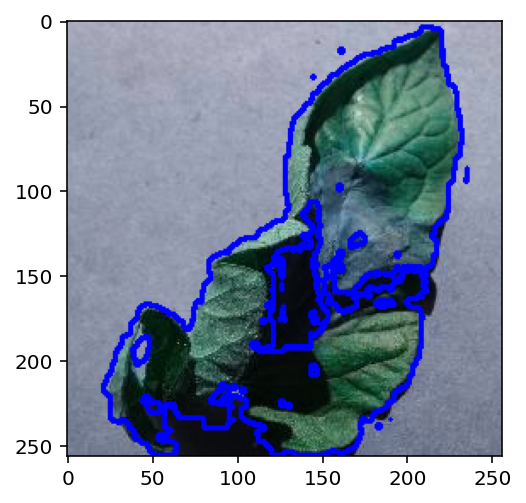

Diagonized as: Tomato   Late blight


Hello Welcome to Plant Disease Detector 



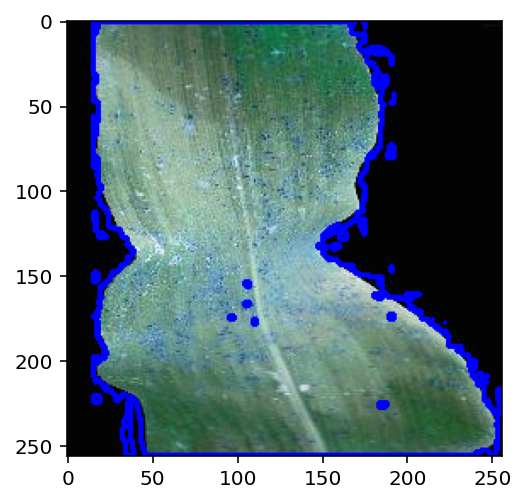

Diagonized as: Corn (maize)   Common rust 


Hello Welcome to Plant Disease Detector 



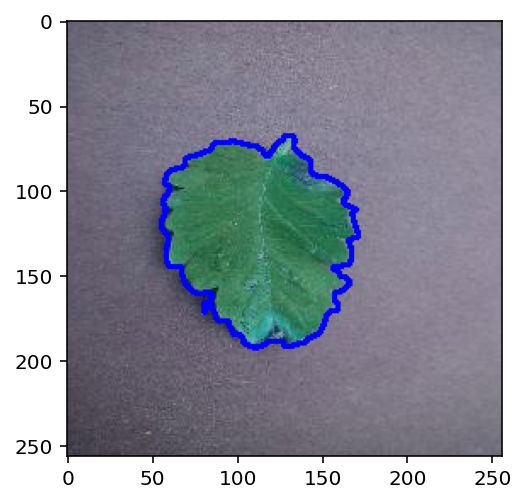

Diagonized as: Tomato   Late blight


Hello Welcome to Plant Disease Detector 



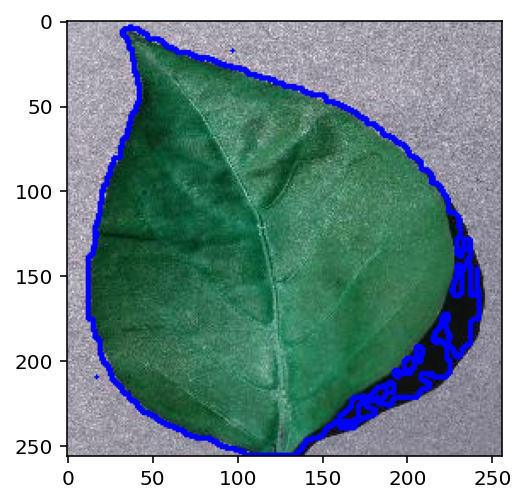

Diagonized as: Pepper, bell   healthy


Hello Welcome to Plant Disease Detector 



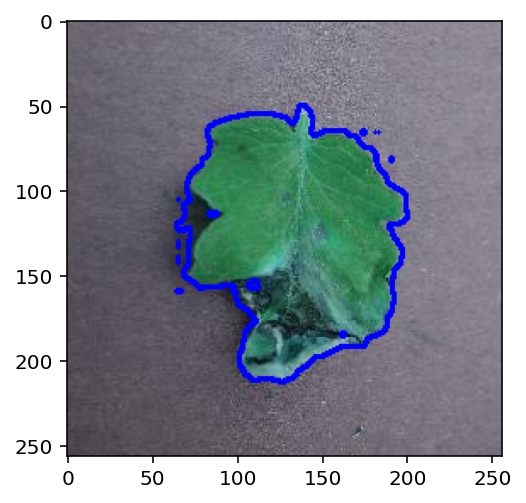

Diagonized as: Tomato   Late blight


Hello Welcome to Plant Disease Detector 



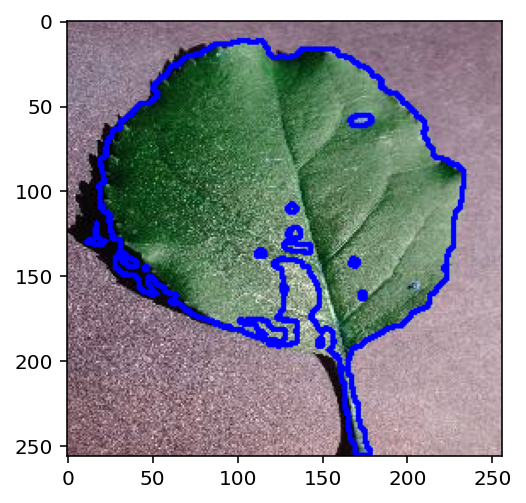

Diagonized as: Apple   Black rot


Hello Welcome to Plant Disease Detector 



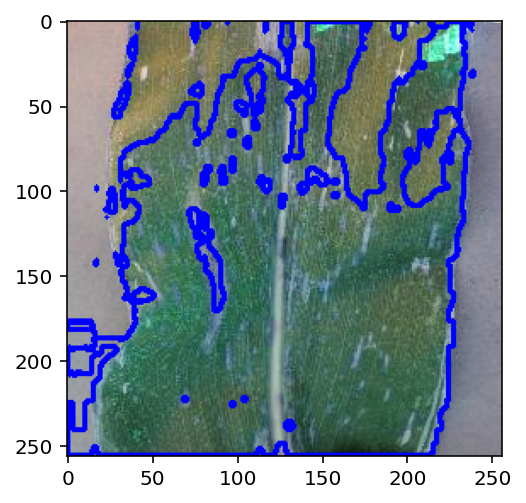

Diagonized as: Corn (maize)   Cercospora leaf spot Gray leaf spot


Hello Welcome to Plant Disease Detector 



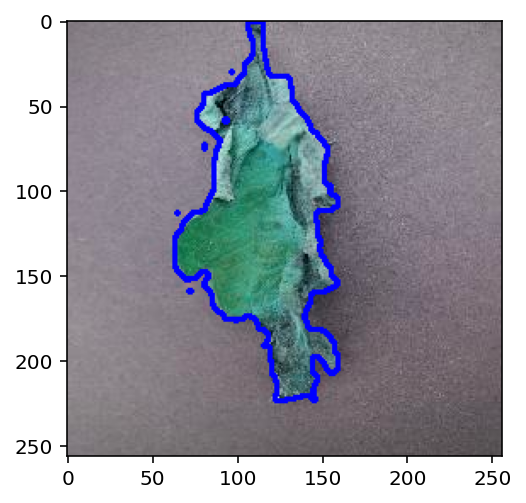

Diagonized as: Tomato   Late blight




In [26]:
healthy_leaves, diseased_leaves = healthy_diseased_data()
for i in range(len(diseased_leaves)):
  run_app(diseased_leaves[i])